In [1]:
%load_ext autoreload
%autoreload 2

# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

import numpy as np
from sdf import *

@sdf3
def gyroid(w = 3.14159, t=0):
    def f(p):
        q = w*p
        x, y, z = (q[:, i] for i in range(3))
        return (np.cos(x)*np.sin(y) + np.cos(y)*np.sin(z) + np.cos(z)*np.sin(x) - t)
    return f

min -0.565721, -0.565721, -0.565721
max 0.565722, 0.565722, 0.565722
step 0.01, 0.01, 0.01

248028 triangles in 0.406836 seconds


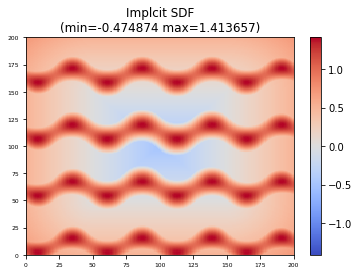

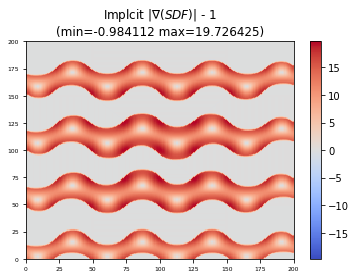

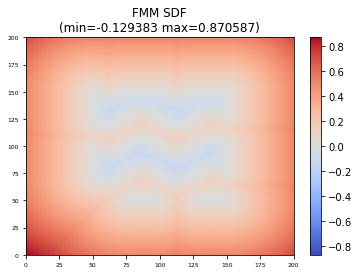

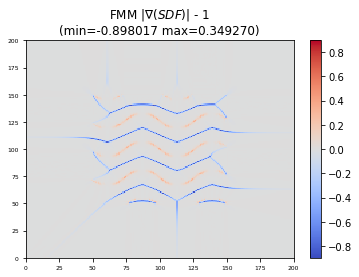

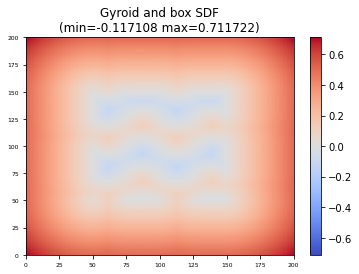

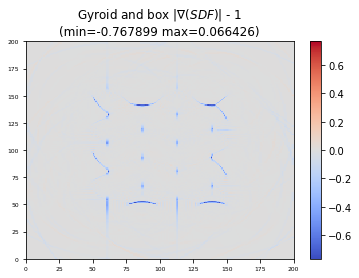

In [4]:
f = gyroid(w=12) & box(1)
f.save('tmp.stl')

from utils.visualizer import SDFVisualize
visualize = SDFVisualize(z_level=0.0, step=0.05, offset=30, nums=200)
visualize.from_implicit(f, bounds_from_mesh='tmp.stl', title="Implcit")
visualize.from_implicit(f, bounds_from_mesh='tmp.stl', title="FMM", fmm=True)
visualize.from_mesh('tmp.stl', title='Gyroid and box')

min -1.17859, -1.17859, -1.17859
max 1.17859, 1.17859, 1.17859
step 0.01, 0.01, 0.01

960900 triangles in 1.716 seconds


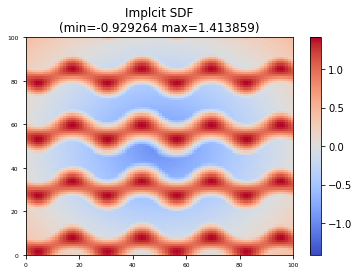

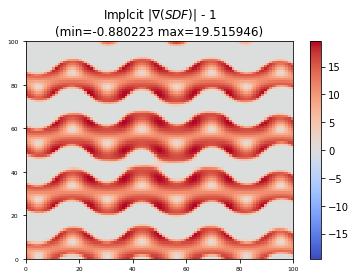

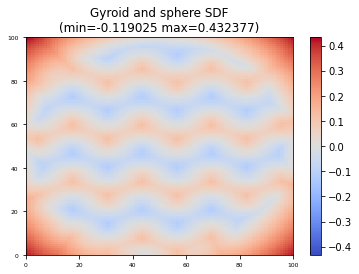

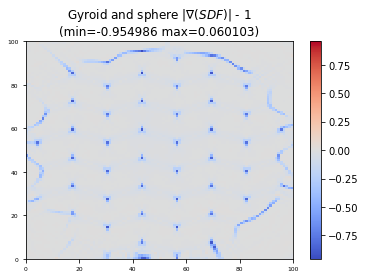

In [9]:
f = sphere(1) & gyroid(w=12)
f.save('tmp.stl')
visualize = SDFVisualize(z_level=0.0, step=0.05, offset=40, nums=100)
visualize.from_implicit(f, bounds_from_mesh='tmp.stl', title="Implcit")
visualize.from_mesh('tmp.stl', title='Gyroid and sphere')